In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()
#engine

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Mea=Base.classes.measurement
Sta=Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
rec_date=session.query(Mea.date).order_by(Mea.date.desc()).first()
recent_date=dt.datetime.strptime(rec_date[0],'%Y-%m-%d')
print("Recent Date:",recent_date)

Recent Date: 2017-08-23 00:00:00


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
twel_months = recent_date - relativedelta(months=12)
twel_months


datetime.datetime(2016, 8, 23, 0, 0)

In [11]:
# Perform a query to retrieve the date and precipitation scores
#engine.execute("select date,prcp from measurement where date between '2016-08-23' and '2017-08-23'order by date ").fetchall()
dt_prcp=session.query(Mea.date, Mea.prcp).filter(Mea.date>=twel_months).filter(Mea.date.between(twel_months,recent_date)).all()
#dt_prcp



In [12]:
#Save the query results as a Pandas DataFrame and set the index to the date column
dte_prcp=pd.DataFrame(dt_prcp,columns = ['date', 'prcp'])
#dte_prcp
#drop nulls
dte_prcp_cln = dte_prcp.dropna(how="any")
#set index
dte_prcp_idx = dte_prcp_cln.set_index("date")
dte_prcp_idx.rename(columns={'prcp':'Percipitation'},inplace=True)
dte_prcp_idx.index.rename("Date",inplace=True)
dte_prcp_idx

,Percipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


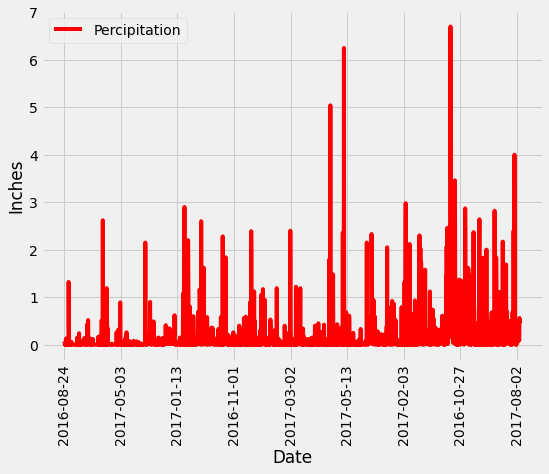

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
dte_prcp_idx.plot(figsize=(8,6),rot=90,color='red')
plt.ylabel('Inches')
plt.legend(fontsize=14)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dte_prcp_idx.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
#engine.execute("select count(station)from station").fetchall()
num_sta=session.query(Sta.station).count()
print(f" The number of Stations in the dataset equals {num_sta}")

 The number of Stations in the dataset equals 9


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
act_stations=session.query(Mea.station, func.count(Mea.date)).group_by(Mea.station).\
order_by(func.count(Mea.station).desc()).all()
act_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
#stations only for API
only_stations=session.query(Mea.station).group_by(Mea.station).\
order_by(func.count(Mea.station).desc()).all()
only_stations

[('USC00519281'),
 ('USC00519397'),
 ('USC00513117'),
 ('USC00519523'),
 ('USC00516128'),
 ('USC00514830'),
 ('USC00511918'),
 ('USC00517948'),
 ('USC00518838')]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_id=act_stations[0][0]
work_horse=session.query(func.min(Mea.tobs),func.max(Mea.tobs),func.avg(Mea.tobs)).filter(Mea.station == station_id).all()


In [29]:
for low,high,average in work_horse:
    
    lha_temp = pd.DataFrame({
        "Lowest_Temp": [low],
        "Highest_Temp": [high],
        "Average_Temp": [round(average,2)]})
lha_temp

,Lowest_Temp,Highest_Temp,Average_Temp
0,54.0,85.0,71.66


In [35]:
# Filter by the station with highest number of observations
last_12= session.query(Mea.date, Mea.tobs).filter(
                        Mea.date >= twel_months).filter(
                        Mea.date <= recent_date).filter(
                        Mea.station == station_id).all()


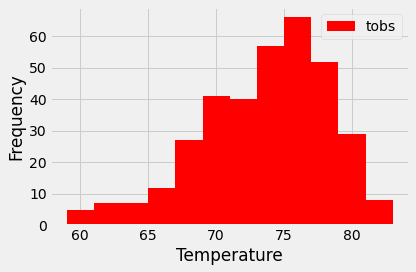

In [22]:
# Save results in DataFrame. set_index(date)
tobs_df = pd.DataFrame(last_12)

# historgram with bins=12
tobs_df.plot.hist(bins=12, color="red")
plt.xlabel('Temperature')
plt.tight_layout()

# Close session

In [31]:
# Close Session
session.close()